In [38]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import math
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from keras.activations import sigmoid
from keras.models import Model ,load_model
from keras.layers import Input, Dense, ConvLSTM2D, Conv2D, Conv1D, MaxPooling2D, Layer, GlobalAveragePooling2D, Reshape, Flatten
from keras.regularizers import L2
from keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.optimizers.legacy import Adam
from keras.saving import register_keras_serializable
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

In [39]:
print(tf.__version__)
print(tf.config.list_physical_devices())
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[1], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2.14.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2 Physical GPUs, 1 Logical GPU


In [40]:
# dirs
DATA_DIR = "./load.csv"

In [41]:
data = pd.read_csv(DATA_DIR)
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%Y/%m/%d %H:%M')
data['Load'] = data['Load'] * 4


In [42]:
# scaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data['Load'].to_numpy().reshape(-1, 1))
data['Load'] = data_scaled

In [43]:
"""
The dataset columns must be the format below:

  index             Timestamp   Load
      0   20xx-xx-xx xx:xx:xx    xxx
      1                   ...    ...
      2                   ...    ...
                                 ...

"""

'\nThe dataset columns must be the format below:\n\n  index             Timestamp   Load\n      0   20xx-xx-xx xx:xx:xx    xxx\n      1                   ...    ...\n      2                   ...    ...\n                                 ...\n\n'

In [44]:
data

,Timestamp,Load
0,2023-01-01 00:00:00,0.445492
1,2023-01-01 00:15:00,0.427049
2,2023-01-01 00:30:00,0.445492
3,2023-01-01 00:45:00,0.420902
4,2023-01-01 01:00:00,0.422951
...,...,...
35035,2023-12-31 22:45:00,0.331148
35036,2023-12-31 23:00:00,0.270492
35037,2023-12-31 23:15:00,0.365574
35038,2023-12-31 23:30:00,0.337295


In [45]:
"""
!! parameter settings
n_predict: predict steps
height: final height of the image:
            height * 2 if the n_predict <= width,
            height * 2 + 1 if the n_predict > width
width: width of the image
n_days: use past n days historical time series data as input (number of channel)
n_window_shift: the shift interval of sliding window
"""
n_predict = 12
height = 4
width = 24
n_days_b = 7
n_days_s = 3
n_window_shift = "15min"

In [46]:
class TimeSeriesImageEncoder():
    def __init__(
            self,
        X: pd.DataFrame,
        n_predict: int,
        height: int,
        width: int,
        n_days_b: int,
        n_days_s: int,
        n_window_shift: str
    ) -> None:
        self.X = X
        self.h = height
        self.m = width
        self.d_b = n_days_b
        self.d_s = n_days_s
        self.shift = n_window_shift
        self.n_predict = n_predict
        self.Lb = self.h * self.m - self.n_predict
        self.Ls = math.ceil(self.n_predict / self.m) * self.m - self.n_predict
        self.timestamps = self.generate_timestamps()
        print(f"Lb: {self.Lb}")
        print(f"Ls: {self.Ls}")

    def generate_timestamps(self):
        start = self.X['Timestamp'].min() + DateOffset(days=self.d_b)
        end = self.X['Timestamp'].max() - DateOffset(minutes=self.n_predict*15)
        timestamps = pd.date_range(start=start, end=end, freq=self.shift)
        return timestamps
    
    def generate_gaussian_noise(self, length, std_dev=0.15):
        noise = np.random.normal(loc=0.5, scale=std_dev, size=length)
        noise = np.clip(noise, 0, 1)
        # noise = np.zeros(shape=length)
        return pd.DataFrame({"Load": noise})
    
    def make_it_symmetric_3d(self, sets_3d):
        symmetry_training_sets = []
        for slice_2d in np.array(sets_3d):
            reversed_slice_2d = slice_2d[::-1]
            combined_slice_2d = np.concatenate((slice_2d, reversed_slice_2d), axis=0)
            symmetry_training_sets.append(combined_slice_2d)
        return np.array(symmetry_training_sets)
    
    def make_it_symmetric_2d(self, sets_2d):
        combined_slice = np.concatenate((sets_2d, sets_2d), axis=0)
        return np.array(combined_slice).reshape(2, int(len(combined_slice)/2))
    

    def encode_b(self):
        training_sets = []
        target_sets = []
        for steps in self.timestamps:
            training_start_b = steps - DateOffset(days=self.d_b-1, hours=23, minutes=45)
            training_end = steps - DateOffset(minutes=(self.n_predict)*15)
            target_start = training_end + DateOffset(minutes=15)
            target_end = steps
            noise = self.generate_gaussian_noise(length=self.n_predict)
            training_data = self.X[(self.X['Timestamp'] >= training_start_b) & (self.X['Timestamp'] <= training_end)]
            training_data = pd.concat([training_data, noise], ignore_index=True)
            target_data = self.X[(self.X['Timestamp'] >= target_start) & (self.X['Timestamp'] <= target_end)]
            if not training_data.empty and not target_data.empty:
                training_reshaped = np.array(training_data['Load']).reshape(self.d_b, self.h, self.m)
                symmetric_3d = self.make_it_symmetric_3d(training_reshaped)
                training_sets.append(symmetric_3d)
                symmetric_2d = self.make_it_symmetric_2d(target_data['Load'])
                target_sets.append(symmetric_2d)
        training_sets = np.array(training_sets)
        target_sets = np.array(target_sets)

        return training_sets, target_sets
    
    def encode_s(self):
        training_sets = []
        for steps in self.timestamps:
            training_subset = []
            point = steps - DateOffset(days=self.d_s-1)
            training_start = point - DateOffset(minutes=(self.m-1)*15)
            # training
            for _ in range(self.d_s-1):
                training_end = training_start + DateOffset(minutes=(self.m-1)*15)
                training_data = self.X[(self.X['Timestamp'] >= training_start) & (self.X['Timestamp'] <= training_end)]
                if not training_data.empty:
                    symmetric_2d = self.make_it_symmetric_2d(training_data['Load'])
                    training_subset.append(symmetric_2d)
                training_start = training_start + DateOffset(days=1)
            training_end = training_start + DateOffset(minutes=(self.m-self.n_predict-1)*15)
            training_data = self.X[(self.X['Timestamp'] >= training_start) & (self.X['Timestamp'] <= training_end)]
            noise = self.generate_gaussian_noise(length=self.n_predict)
            training_data = pd.concat([training_data, noise], ignore_index=True)
            symmetric_2d = self.make_it_symmetric_2d(training_data['Load'])
            training_subset.append(symmetric_2d)
            training_sets.append(training_subset)
        training_sets = np.array(training_sets)
        return training_sets
    
    def encode(self):
        training_sets_b, target_sets = self.encode_b()
        training_sets_s = self.encode_s()
        training_sets_b = np.transpose(training_sets_b, (0, 2, 3, 1))
        training_sets_s = np.transpose(training_sets_s, (0, 2, 3, 1))
        return training_sets_b, training_sets_s, target_sets

In [47]:
encoder = TimeSeriesImageEncoder(
    X=data,
    n_predict=n_predict,
    height=height,
    width=width,
    n_days_b=n_days_b,
    n_days_s=n_days_s,
    n_window_shift=n_window_shift
)
encoded_Xb, encoded_Xs, encoded_y = encoder.encode()

Lb: 84
Ls: 12


In [48]:
print(encoded_Xb.shape)
print(encoded_Xs.shape)
print(encoded_y.shape)

(34356, 8, 24, 7)
(34356, 2, 24, 3)
(34356, 2, 12)


In [49]:
MONTH_TIME_STEP = math.floor(encoder.timestamps.shape[0] / 24)
X_test_b = []
X_test_s = []
y_test = []
minList = []
maxList = []
for i in range(0, 24):
    start = (i+1)*MONTH_TIME_STEP-(192*(i+1))
    end = (i+1)*MONTH_TIME_STEP-(192*i)
    X_test_b.append(encoded_Xb[start:end])
    X_test_s.append(encoded_Xs[start:end])
    y_test.append(encoded_y[start:end])
    encoded_Xb = np.concatenate([encoded_Xb[:start], encoded_Xb[end:]])
    encoded_Xs = np.concatenate([encoded_Xs[:start], encoded_Xs[end:]])
    encoded_y = np.concatenate([encoded_y[:start], encoded_y[end:]])

In [50]:
X_test_b = np.concatenate([i for i in X_test_b])
X_test_s = np.concatenate([i for i in X_test_s])
y_test = np.concatenate([i for i in y_test])

In [51]:
X_train_b = encoded_Xb
X_train_s = encoded_Xs
y_train = encoded_y

In [52]:
print(np.array(X_train_b).shape)
print(np.array(X_train_s).shape)
print(np.array(X_test_b).shape)
print(np.array(X_test_s).shape)
print(np.array(y_train).shape)
print(np.array(y_test).shape)

(29748, 8, 24, 7)
(29748, 2, 24, 3)
(4608, 8, 24, 7)
(4608, 2, 24, 3)
(29748, 2, 12)
(4608, 2, 12)


In [53]:
@register_keras_serializable('ECALayer')
class ECALayer(Layer):
    def __init__(self, gamma=2, b=1, **kwargs):
        super(ECALayer, self).__init__(**kwargs)
        self.gamma = gamma
        self.b = b

    def build(self, input_shape):
        c = input_shape[-1]
        self.t = max(1, int(abs((tf.math.log(float(c)) / tf.math.log(2.0) + self.b) / self.gamma)))
        self.conv = Conv1D(filters=1, kernel_size=self.t, padding='same', use_bias=False)
        super(ECALayer, self).build(input_shape)

    def call(self, inputs):
        # Global Average Pooling over the spatial dimensions to produce a (batch_size, 1, channels) tensor
        x = GlobalAveragePooling2D()(inputs)
        x = Reshape((1, -1))(x)
        x = self.conv(x)
        x = sigmoid(x)
        x = tf.squeeze(x, axis=1)  # Squeeze to make it (batch_size, channels)
        
        # Multiply weights across channels
        return inputs * x[:, tf.newaxis, tf.newaxis, :]

    def get_config(self):
        config = super(ECALayer, self).get_config()
        config.update({
            'gamma': self.gamma,
            'b': self.b
        })
        return config

In [54]:
@register_keras_serializable('AverageLayer')
class AverageLayer(Layer):
    def __init__(self, **kwargs):
        super(AverageLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return (inputs[0] + inputs[1]) / 2

In [55]:
# def create_model(input_shape_b, input_shape_s, num_outputs):
#     inputs_b = Input(shape=input_shape_b)
#     inputs_s = Input(shape=input_shape_s)
#     conv1 = Conv2D(filters=32, kernel_size=8, padding="same", activation="tanh")(inputs_b)
#     conv2 = Conv2D(filters=64, kernel_size=8, padding="same", activation="tanh")(conv1)
#     conv2 = Reshape((1, *conv2.shape[1:]))(conv2)  
#     lstm1 = ConvLSTM2D(filters=96, kernel_size=8, padding="same", activation="tanh", return_sequences=True, dropout=0.3)(conv2)
#     lstm2 = ConvLSTM2D(filters=96, kernel_size=8, padding="same", activation="tanh", return_sequences=False, dropout=0.3)(lstm1)
#     eca1 = ECALayer()(lstm2)
#     conv3 = Conv2D(filters=64, kernel_size=8, padding="same", activation="tanh")(eca1)
#     conv4 = Conv2D(filters=32, kernel_size=8, padding="same", activation="tanh")(conv3)
#     maxpool1 = MaxPooling2D(pool_size=10, padding="same")(conv4)
#     flatten1 = Flatten()(maxpool1)
#     dense1 = Dense(2*num_outputs, activation="linear")(flatten1)
#     outputs1 = Reshape((2, 12))(dense1)

#     conv5 = Conv2D(filters=8, kernel_size=2, padding="same", activation="tanh")(inputs_s)
#     conv6 = Conv2D(filters=16, kernel_size=2, padding="same", activation="tanh")(conv5)
#     conv6 = Reshape((1, *conv6.shape[1:]))(conv6)  
#     lstm3 = ConvLSTM2D(filters=24, kernel_size=2, padding="same", activation="tanh", return_sequences=True, dropout=0.3)(conv6)
#     lstm4 = ConvLSTM2D(filters=24, kernel_size=2, padding="same", activation="tanh", return_sequences=False, dropout=0.3)(lstm3)
#     eca2 = ECALayer()(lstm4)
#     conv7 = Conv2D(filters=16, kernel_size=2, padding="same", activation="tanh")(eca2)
#     conv8 = Conv2D(filters=8, kernel_size=2, padding="same", activation="tanh")(conv7)
#     maxpool2 = MaxPooling2D(pool_size=5, padding="same")(conv8)
#     flatten2 = Flatten()(maxpool2)
#     dense2 = Dense(2*num_outputs, activation="linear")(flatten2)
#     outputs2 = Reshape((2, 12))(dense2)

#     final_output = AverageLayer()([outputs1, outputs2])
#     model = Model(inputs=[inputs_b, inputs_s], outputs=final_output)

#     return model


In [56]:
def create_model(input_shape_b, num_outputs):
    inputs_b = Input(shape=input_shape_b)
    conv1 = Conv2D(filters=32, kernel_size=8, padding="same", activation="tanh")(inputs_b)
    conv2 = Conv2D(filters=64, kernel_size=8, padding="same", activation="tanh")(conv1)
    conv2 = Reshape((1, *conv2.shape[1:]))(conv2)  
    lstm1 = ConvLSTM2D(filters=96, kernel_size=8, padding="same", activation="tanh", return_sequences=True, dropout=0.3)(conv2)
    lstm2 = ConvLSTM2D(filters=96, kernel_size=8, padding="same", activation="tanh", return_sequences=False, dropout=0.3)(lstm1)
    eca1 = ECALayer()(lstm2)
    conv3 = Conv2D(filters=64, kernel_size=8, padding="same", activation="tanh")(eca1)
    conv4 = Conv2D(filters=32, kernel_size=8, padding="same", activation="tanh")(conv3)
    maxpool1 = MaxPooling2D(pool_size=10, padding="same")(conv4)
    flatten1 = Flatten()(maxpool1)
    dense1 = Dense(2*num_outputs, activation="linear")(flatten1)
    outputs1 = Reshape((2, 12))(dense1)
    model = Model(inputs=inputs_b, outputs=outputs1)

    return model

In [57]:
# model = create_model(input_shape_b=X_train_b.shape[1:], input_shape_s=X_test_s.shape[1:], num_outputs=12)
# model.compile(optimizer=Adam(learning_rate=1e-4), loss="mse")
# model.summary()


In [58]:


# with tf.device("/GPU:0"):
#     history = model.fit(
#         [X_train_b, X_train_s],
#         y_train,
#         verbose=1,
#         epochs=120,
#         batch_size=96,
#         callbacks=[tensorboard_callback, early_stopping_callback, reduce_lr_callback]
#     )

with tf.device("/GPU:1"):
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    %load_ext tensorboard

    tensorboard_callback = TensorBoard(logdir, histogram_freq=1)
    early_stopping_callback = EarlyStopping(monitor="loss", patience=10, min_delta=5e-5)
    reduce_lr_callback = ReduceLROnPlateau(monitor="loss", factor=0.3, patience=5, verbose=1, min_lr=1e-7)
    model = create_model(input_shape_b=X_train_b.shape[1:], num_outputs=12)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss="mse")
    model.summary()
    history = model.fit(
        X_train_b,
        y_train,
        verbose=1,
        epochs=120,
        batch_size=32,
        callbacks=[tensorboard_callback, early_stopping_callback, reduce_lr_callback]
    )
 


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8, 24, 7)]        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 24, 32)         14368     
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 24, 64)         131136    
                                                                 
 reshape_2 (Reshape)         (None, 1, 8, 24, 64)      0         
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 1, 8, 24, 96)      3932544   
                                                                 
 conv_lstm2d_3 (ConvLSTM2D)  (None, 8, 24, 96)         4718976   
                                   

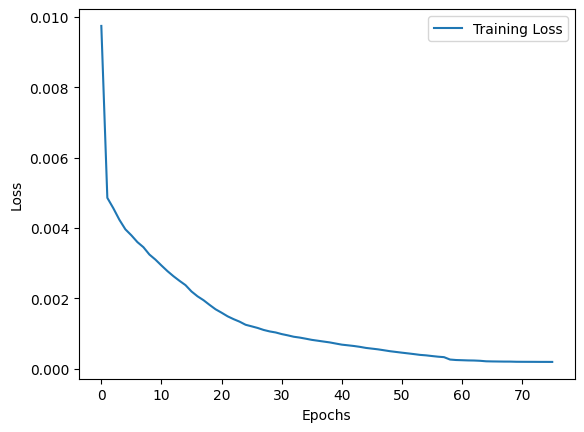

In [59]:
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [60]:

y_pred = model.predict([X_test_b])


  9/144 [>.............................] - ETA: 1s

2024-04-30 11:50:06.555040: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'model_1/conv_lstm2d_2/while/body/_1/model_1/conv_lstm2d_2/while/mul_6' -> 'model_1/conv_lstm2d_2/while/body/_1/model_1/conv_lstm2d_2/while/add_5', 'model_1/conv_lstm2d_2/while/body/_1/model_1/conv_lstm2d_2/while/convolution_6' -> 'model_1/conv_lstm2d_2/while/body/_1/model_1/conv_lstm2d_2/while/add_4', 'model_1/conv_lstm2d_2/while/body/_1/model_1/conv_lstm2d_2/while/clip_by_value_2' -> 'model_1/conv_lstm2d_2/while/body/_1/model_1/conv_lstm2d_2/while/mul_9', 'model_1/conv_lstm2d_2/while/body/_1/model_1/conv_lstm2d_2/while/clip_by_value' -> 'model_1/conv_lstm2d_2/while/body/_1/model_1/conv_lstm2d_2/while/mul_7', 'model_1/conv_lstm2d_3/while/body/_49/model_1/conv_lstm2d_3/while/Tanh_1' -> 'model_1/conv_lstm2d_3/while/body/_49/model_1/conv_lstm2d_3/while/mul_9', 'model_1/conv_lstm2d_3/while/b

144/144 [==============================] - 2s 14ms/step


In [61]:

y_pred_final = y_pred.sum(axis=1)/2
y_test_final = y_test.sum(axis=1)/2
print(y_test_final.shape)
print(y_pred_final.shape)
mse = mean_squared_error(y_test_final, y_pred_final)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test_final, y_pred_final)
r2 = r2_score(y_test_final, y_pred_final)
print("-" * 86)
print(f'mse: {mse:.4f}')
print(f'rmse: {rmse:.4f}')
print(f'mae: {mae:.4f}')
print(f'r2: {r2:.4f}')
print("-" * 86)

(4608, 12)
(4608, 12)
--------------------------------------------------------------------------------------
mse: 0.0042
rmse: 0.0644
mae: 0.0417
r2: 0.8136
--------------------------------------------------------------------------------------


In [62]:
model.save("./model/image_inpainting_CNN_LSTM.keras")